## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [179]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sys
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(root_path)

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from src import phase_classification as pc

data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [180]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)

In [181]:
file_name = '[train]IBL_topic_distribution_by_utterance_minimum_5_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [182]:
df_data.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.009546,0.012683,0.006349,0.005774,0.003684,0.005008,0.004698,0.008680,0.012694,0.015815,...,0.011693,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.102344,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009057,0.011282,...,0.008342,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.102352,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009055,0.011302,...,0.008342,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.005717,0.007596,0.003803,0.077458,0.002207,0.003000,0.002814,0.005199,0.007603,0.009472,...,0.007004,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.111640,0.004865,0.002435,0.002215,0.001413,0.001921,0.001802,0.003329,0.004869,0.006066,...,0.004486,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


In [183]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


### split data

In [184]:
filter_rows = list(range(1,61))+[68,69]
filter_labels = [61]

In [185]:
train_set,validation_set = pc.split_df(df_data,0.2)
X_train,y_train = pc.get_data_from_dict(train_set,filter_rows)
X_val,y_val = pc.get_data_from_dict(validation_set,filter_rows)

validation set phase 1: 80
validation set phase 2: 35
validation set phase 3: 81
validation set phase 4: 12
validation set phase 5: 110


In [186]:
len(X_train[0])

62

In [187]:
all_set,_ = pc.split_df(df_data,0.0)
X_all,y_all = pc.get_data_from_dict(all_set,filter_rows)

validation set phase 1: 0
validation set phase 2: 0
validation set phase 3: 0
validation set phase 4: 0
validation set phase 5: 0


### Classify first layer

In [188]:
len(X_train[0])

62

In [189]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

### Select features

In [190]:
matrix = np.array(X_train)

In [191]:
from scipy.stats import ks_2samp

In [192]:
def get_ks_per_topic(new_y,matrix):
    aux = []
    for i in range(matrix.shape[1]):
        sample_1 = []
        sample_2 = []
        for j in range(matrix.shape[0]):
            if new_y[j] == 1:
                sample_1.append(matrix[j,i])
            else:
                sample_2.append(matrix[j,i])
        aux.append(ks_2samp(sample_1,sample_2).pvalue)
    return aux

In [193]:
kss = []
less_than = []
for i in range(1,6):
    new_y = [1 if j==i else 0 for j in y_train]
    ks_per_topic = get_ks_per_topic(new_y,matrix)
    less_than.append([j for j in range(len(ks_per_topic)) if ks_per_topic[j]<0.05])
    kss.append(ks_per_topic)

In [194]:
selected_features = list(set(less_than[0]+less_than[1]+less_than[2]+less_than[3]+less_than[4]))
#selected_features = [61]

In [220]:
np.sort(selected_features)

array([ 3, 20, 22, 26, 29, 33, 39, 43, 50, 55, 61])

In [195]:
X_train1 = [element[selected_features] for element in X_train] 
X_val1 = [element[selected_features] for element in X_val] 
X_all = [element[selected_features] for element in X_all] 
X_val = X_val1
X_train = X_train1

In [196]:
svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True)#,class_weight=class_weight)
svc.fit(X_train1, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train1, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val1, y_val)))

Accuracy of SVM classifier on training set: 0.50
Accuracy of SVM classifier on test set: 0.51


In [197]:
pred = svc.predict(X_val1)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.51      0.66      0.58        80
           2       0.00      0.00      0.00        35
           3       0.76      0.27      0.40        81
           4       0.00      0.00      0.00        12
           5       0.47      0.79      0.59       110

   micro avg       0.51      0.51      0.51       318
   macro avg       0.35      0.35      0.31       318
weighted avg       0.48      0.51      0.45       318



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,53,0,2,0,25
Phase 2,13,0,1,0,21
Phase 3,18,0,22,0,41
Phase 4,0,0,0,0,12
Phase 5,19,0,4,0,87


### Find threshold

Look for the distance to the second max

In [198]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([41., 46., 37., 47., 40., 42., 44., 18.,  1.,  2.]),
 array([0.03256959, 0.11735062, 0.20213166, 0.2869127 , 0.37169374,
        0.45647478, 0.54125582, 0.62603686, 0.7108179 , 0.79559893,
        0.88037997]),
 <a list of 10 Patch objects>)

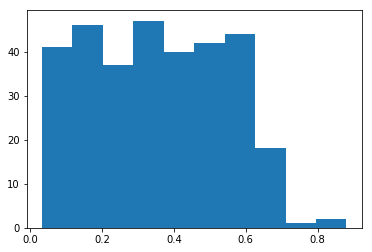

In [199]:
plt.hist(prob_pred)

In [200]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

(array([ 0.,  0., 15., 26., 32., 26., 26., 20.,  5.,  3.,  1.,  1.,  0.,
         0.]),
 array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
        0.75, 0.8 , 0.85, 0.9 ]),
 <a list of 14 Patch objects>)

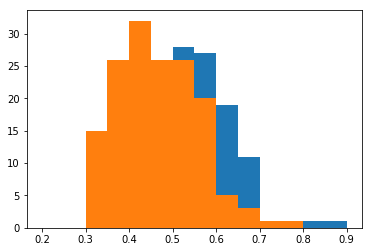

In [201]:
plt.hist(values_ok,np.arange(0.2,.95,.05))
plt.hist(values_not_ok,np.arange(0.2,.95,.05))

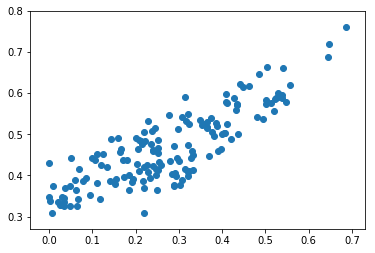

In [202]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [203]:
t = 0.6

In [204]:
output_first_layer = pc.first_layer_classifier(X_all,t,svc)
comparison = list(zip(output_first_layer,y_all))

In [205]:
df_data['first_layer'] = output_first_layer

### Second layer

In [206]:
import importlib
importlib.reload(pc)

<module 'src.phase_classification' from 'C:\\Users\\CATALINA ESPINOZA\\Documents\\ciae\\Classification_IBL\\src\\phase_classification.py'>

In [207]:
second_layer,coeff = pc.second_layer_combination_before_after(X_all,df_data,svc)

In [208]:
phases = df_data.phase.values
s,v1,v2,v3 = pc.get_linear_system(X_all,svc,phases)
sol,As = pc.get_solution_linear_system(s,v1,v2,v3)

In [209]:
from scipy.optimize import minimize

In [210]:
As,bs = pc.get_elements_linear_system(s,v1,v2,v3)
fun = lambda x: np.sum([np.linalg.norm(np.dot(As[i],x)-bs[i]) for i in range(len(s))])
cons = ({'type': 'eq', 'fun': lambda x:  x[0]+x[1]+x[2]-1})
sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons)
sol.x

array([0.42513002, 0.28820904, 0.28666094])

In [211]:
fun(sol.x)

1389.7736094356428

In [212]:
fun([0,1,0])

1399.0826840261368

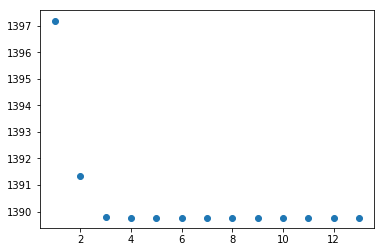

In [213]:
x = range(1,14)
y = []
for i in range(1,14):
    sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons,options={'maxiter':i})
    y.append(fun(sol.x))
plt.scatter(x,y)

In [214]:
"Number of not predicted {}".format(second_layer.count(-1))

'Number of not predicted 0'

In [215]:
df_data['second_layer'] = second_layer

In [216]:
df = pd.DataFrame(confusion_matrix(y_all, second_layer),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
print(classification_report(y_all, second_layer))
df

              precision    recall  f1-score   support

           1       0.53      0.69      0.60       403
           2       0.00      0.00      0.00       175
           3       0.79      0.43      0.56       406
           4       0.00      0.00      0.00        62
           5       0.49      0.75      0.59       554

   micro avg       0.54      0.54      0.54      1600
   macro avg       0.36      0.37      0.35      1600
weighted avg       0.50      0.54      0.50      1600



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,278,0,19,0,106
Phase 2,42,0,0,0,133
Phase 3,93,0,174,0,139
Phase 4,0,0,3,0,59
Phase 5,112,0,25,0,417


In [217]:
with open(os.path.join(data_path,'classifier_svm_linear_combination_svc_selected_features.pickle'),'wb') as f:
    pickle.dump(svc,f)
    pickle.dump(coeff,f)

In [218]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_all, y_all)))

Accuracy of SVM classifier on training set: 0.50
